In [487]:
import torch
import torch.nn as nn
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [488]:
from utils.common_functions import get_emotions, get_sentiment_dict
emotions = list(get_emotions().values())
trends = ["approval","toxic","obscene", 'insult', "threat", "hate", "offensive", "neither"]
sentiment_dict = get_sentiment_dict()
print(sentiment_dict)
sentiments = list(sentiment_dict.keys())
print(sentiment_dict.keys())


{'positive': ['amusement', 'excitement', 'joy', 'love', 'desire', 'optimism', 'caring', 'pride', 'admiration', 'gratitude', 'relief', 'approval'], 'negative': ['fear', 'nervousness', 'remorse', 'embarrassment', 'disappointment', 'sadness', 'grief', 'disgust', 'anger', 'annoyance', 'disapproval'], 'ambiguous': ['realization', 'surprise', 'curiosity', 'confusion'], 'neutral': ['neutral']}
dict_keys(['positive', 'negative', 'ambiguous', 'neutral'])


In [489]:
def find_indices(sublist, main_list):
    # Create a dictionary mapping elements to their indices in the main list
    index_dict = {val: idx for idx, val in enumerate(main_list)}
    
    # Retrieve indices of elements from the sublist in the main list
    indices = [index_dict[val] for val in sublist]
    return indices

def sum_elements_by_indices(input_list, indices):
    total = sum(input_list[i] for i in indices)
    return total

# Example usage:
# main_list = [10, 20, 30, 40, 50, 60, 70]
# sublist = [20, 40, 60]

# result = find_indices(main_list, sublist)
# result

In [490]:
file_name = 'fox-new-york-could-face'
# file_name = 'fox-us-security-council-vote'
# file_name = 'fox-4-abortion'

df_emotion = pd.read_csv(f'/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/reply-tree/csv/{file_name}-emotions.csv')
df_trend = pd.read_csv(f'/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/reply-tree/csv/{file_name}-trends.csv')

In [491]:
df_emotion.head()

,Unnamed: 0,id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,1,0.056256,0.028770,0.031015,0.074168,0.061766,0.025045,0.025844,0.038505,...,0.033407,0.004762,0.032794,0.004838,0.026677,0.002986,0.008717,0.022151,0.012818,0.318049
1,1,2,0.047936,0.031079,0.030752,0.070195,0.060472,0.022767,0.025994,0.033738,...,0.039075,0.004964,0.025938,0.006520,0.028317,0.003231,0.008511,0.023083,0.013171,0.338398
2,2,3,0.068041,0.026878,0.027380,0.062444,0.062327,0.030113,0.028271,0.044934,...,0.034768,0.006207,0.033658,0.004758,0.029611,0.003825,0.010179,0.022379,0.015505,0.268296
3,3,4,0.061657,0.033352,0.029867,0.071862,0.064259,0.028050,0.031596,0.036436,...,0.038043,0.006670,0.035646,0.006401,0.032235,0.004902,0.010973,0.023081,0.015701,0.249566
4,4,5,0.059052,0.031462,0.029537,0.070088,0.068205,0.029266,0.030995,0.037274,...,0.044986,0.007705,0.034155,0.009013,0.033838,0.006043,0.012085,0.027586,0.018263,0.217677


In [492]:
df_trend.head()

,Unnamed: 0,id,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,0,1,0.068936,0.185605,0.097468,0.004318,0.081541,0.033917,0.154603,0.373610
1,1,2,0.119411,0.159864,0.081358,0.004549,0.080507,0.031381,0.206910,0.316019
2,2,3,0.044903,0.197656,0.109991,0.008711,0.095442,0.044272,0.144211,0.354814
3,3,4,0.031249,0.146739,0.066025,0.005766,0.068670,0.035229,0.084432,0.561891
4,4,5,0.068299,0.174753,0.088030,0.004323,0.081952,0.036314,0.171916,0.374413


In [493]:

positive_indices = find_indices(sentiment_dict['positive'], emotions)
negative_indices = find_indices(sentiment_dict['negative'], emotions)
ambiguous_indices = find_indices(sentiment_dict['ambiguous'], emotions)
neutral_indices = find_indices(sentiment_dict['neutral'], emotions)


def get_emotion_score(comment_id):
    row_index = df_emotion.loc[df_emotion['id'] == comment_id].index[0]
    scores = df_emotion.iloc[row_index][2:]
    return list(scores)

def get_trend_score(comment_id):
    row_index = df_trend.loc[df_trend['id'] == comment_id].index[0]
    scores = df_trend.iloc[row_index][2:]
    return list(scores)

def get_polarity_score(e_scores):
    scores = [sum_elements_by_indices(e_scores, positive_indices), sum_elements_by_indices(e_scores, negative_indices), 
                sum_elements_by_indices(e_scores, ambiguous_indices), sum_elements_by_indices(e_scores, neutral_indices)]
    return scores
    

In [494]:
import pickle

# Load the XGBoost model from the .pkl file
with open('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/model_save/trend_pred/grid_xgb.pickle', 'rb') as file:
    xgb_model = pickle.load(file)

def get_xgb_trend(e_score):
    df_score = pd.DataFrame([e_score], columns=emotions)
    y_pred = xgb_model.predict_proba(df_score)
    return y_pred.tolist()[0]

## Create the reply tree with required info

In [495]:
from utils.classes import Tree

def replyTree(node):
    # global comments
    print("node:", node['id'], node['text'])

    if len(node['children']) == 0:
        
        text = node['text'] #get_clean_data(node)
        
        e_scores = get_emotion_score(node['id'])
        t_scores_xgb = get_xgb_trend(e_scores)
        t_scores_tbert = get_trend_score(node['id'])
        # polarity = get_polarity_score(e_scores)
        
        return Tree(node['id'], text, [], e_scores, t_scores_tbert, t_scores_xgb, polarity=0)

    children = []
    for ch in node['children']:
        children.append(replyTree(ch))
    
    text = node['text'] #get_clean_data(node)

    e_scores = get_emotion_score(node['id'])
    t_scores_xgb = get_xgb_trend(e_scores)
    t_scores_tbert = get_trend_score(node['id'])
    # polarity = get_polarity_score(e_scores)

    return Tree(node['id'], text, children, e_scores, t_scores_tbert, t_scores_xgb, polarity=0)

In [496]:
from utils.agg_functions import base_method, method_with_std_zscore, method3
from utils.agg_functions import dempster_shafer, uninorm_aggregation

def varify(x):
    print("1 == ", sum(x))
    return

def Aggregation(Sa, type, num_labels):
    if type == "method1": # Addition and Normalization
        return base_method(Sa, num_labels)
    if type == "method2": # Z-score
        return method_with_std_zscore(Sa, num_labels, distance=1.5)
    if type == "method3": # Weighet Average 
        return method3(Sa, num_labels)
    if type == "ds": # Dempster Shafer
        A = Sa[0]
        Sa = Sa[1:-1]
        for i in Sa:
            A = dempster_shafer(A, i, num_labels)
        return A
    if type == 'uninorm': # Uninorm Aggregation
        A = uninorm_aggregation(Sa, num_labels)
        # varify(row_totals)
        return A

## Travers the reply tree and calculate and aggregate the emotions score

In [497]:
max_depth = 0
max_children = 0
total_node = 0

def RECUR(node, type, depth, num_labels):
    global max_depth
    global max_children
    global total_node
    max_children = max(max_children, len(node.children))
    max_depth = max(max_depth, depth)
    total_node += len(node.children)

    if len(node.children) == 0:
        return

    Se = []
    Stt = []
    Stx = []
    for reply in node.children:
        RECUR(reply, type, depth+1, num_labels)
        Se.append(reply.e_scores)
        Stt.append(reply.t_scores_tbert)
        Stx.append(reply.t_scores_xgb)

    # Emotion score aggregation
    # Se = []
    Se.append(node.e_scores)
    # Se.append(Ae)
    Ae = Aggregation(Se, type, 28)

    # T-BERT's trend score aggregation
    # St = []
    Stt.append(node.t_scores_tbert)
    # St.append(At)
    Att = Aggregation(Stt, type, 8)

    # XGB trend score aggregation
    # St = []
    Stx.append(node.t_scores_xgb)
    # St.append(At)
    Atx = Aggregation(Stt, type, 8)

    node.e_scores = Ae
    node.t_scores_tbert = Att
    node.t_scores_xgb = Atx
    # print("comment id: ", node.id)
    # print("e scores: ", node.e_scores)
    # print("Sub-tree Matrix: ", Se)
    node.polarity = get_polarity_score(node.e_scores)


## Load Comment Data

In [498]:
# '14-06-2023 12:32:07','14-06-2023 13:20:27','14-06-2023 19:33:02'

In [499]:
def get_time(file_name):
    return ' '.join(file_name[-24:-5].split('_'))

def get_file_name(file_name, method):
    return str(' '.join(file_name[0:-25].split('_'))) + '_' + method


# print(get_file_name('fox-white-house-flew-14-06-2023_19:33:02.json'))

In [500]:
import json
import os
log_data = {}
log_data['timestamps'] = []
method = 'method3'
num_labels = 8

parent_path = '/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/reply-tree/json/'
file = f'{file_name}.json'
with open(os.path.join(parent_path, file)) as f:
   comment_json = json.load(f)
   log_data['timestamps'].append(get_time(file))
   file_name = get_file_name(file, method)

In [501]:
# comment_json

In [502]:

def tokenize_reply_tree(comment_json):
    reply_tree = {}
    emotion_scores = []
    for i, json in enumerate(comment_json):
        # print("Json:", json)
        reply_tree[i] = replyTree(json)
        emotion_scores.append(reply_tree[i].e_scores)
        # print("reply_tree: ", reply_tree[i].scores)
    return reply_tree, emotion_scores

In [503]:

reply_tree, emotion_scores = tokenize_reply_tree(comment_json)

print(len(reply_tree))

node: 1 Citizens on both sides of the aisle need to start protesting gerrymandering.  Why do we tolerate politicians picking their voters, rather than voters picking their politicians?  Districts should be drawn to the most compact geographical area possible, to encompass a set number of citizens.  This should be done without regard to race, religion, or political persuasion.  Districts should never look like snakes.  Snakes are bad.  Look at the Illinois congressional district map for an example of extreme gerrymandering.
node: 2 I really like "Why do we tolerate politicians picking their voters, rather than voters picking their politicians?"  That says it perfectly. I think the machinery of vote manipulation is so sophisticated that it is literally impossible to fix this.  The ONLY solution is that every seat is state wide.  
node: 3 You can't have every seat be statewide. The largest cities would dominate the vote and pick all the seats. The idea of districts is to protect the minor

node: 124 Redistricting for the benefit of one party over another should be a real issue in our country. Instead, nothing is done about it.
node: 125 That's not true, some states have taken action. My state, Colorado, uses an independent redistricting commission. 
node: 126 CO is never a great example to illustrate true democracy - it's completely dem-infested.
node: 127 Well they still vote for Democrats most of the time anyway, and haven't learned anything from that, so I'm not sure how this will effect the state as a whole anyway. NY and California are circling the bowl. 
node: 128 No, we don't!
node: 129 It’s not really a legal win in a political case when the judges are politically biased.
node: 130 It is not the judges - they just interpret the laws.   The problem is the state legislature, which is dependent upon gerrymandering to stay in control.
node: 131 Actually the judges are contributing...Every judge is elected or appointed with a D or R by their name...just like politicia

In [504]:
multiple_tree_final_escores = []
multiple_tree_final_tscores = []
multiple_tree_final_polarity = []

log_data['max_depth'] = []
log_data['max_replies'] = []
log_data['total_node'] = []
log_data['f_level_comment'] = []

for i, id, in enumerate(comment_json):
    RECUR(reply_tree[i], method, 0, num_labels)

print("Max Depth: ", max_depth)
print("Max replies: ", max_children)
print("Total Node: ", total_node + len(comment_json))
print("First level comment: ", len(comment_json))

log_data['max_depth'].append(max_depth)
log_data['max_replies'].append(max_children)
log_data['total_node'].append(total_node + len(comment_json))
log_data['f_level_comment'].append(len(comment_json))
max_depth = 0
max_children = 0
total_node = 0

# First level comment aggregation
escores = []
tscores_tbert = []
tscores_xgb = []
polarity = []

for i, id, in enumerate(comment_json):
    # print(f"Comment# {i}: {reply_tree[i].text}")
    Ae = list(reply_tree[i].e_scores)
    escores.append(Ae)

    Att = list(reply_tree[i].t_scores_tbert)
    tscores_tbert.append(Att)

    Atx = list(reply_tree[i].t_scores_xgb)
    tscores_xgb.append(Atx)

    # mx = max(A)
    # idx = A.index(mx)
    # print("max: ", mx, "index: ", A)
# print("scores-matrix: ", scores)
final_escore = Aggregation(escores, method, 28)
final_polarity = get_polarity_score(final_escore)

final_tscore_tbert = Aggregation(tscores_tbert, method, 8)
final_tscore_xgb = Aggregation(tscores_xgb, method, 8)
     
log_data['aggregation'] = method
log_data['emotion_scores'] = final_escore
log_data['trend_scores_tbert'] = final_tscore_tbert
log_data['trend_scores_xgb'] = final_tscore_xgb
log_data['polarity'] = final_polarity

Max Depth:  2
Max replies:  13
Total Node:  1064
First level comment:  564


In [505]:
# file_name = 'fox-new-york-could-face'
# file_name = 'fox-us-security-council-vote'
# file_name = 'fox-4-abortion'
# def get_filename():
#     return file_name

# method = 'method2'
# # method = 'method3'
# def get_method():
#     return method

In [506]:
df_score = pd.DataFrame([final_escore], columns=emotions)

In [507]:
df_score.head()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0.066248,0.033523,0.029329,0.067314,0.064107,0.027849,0.028549,0.037598,0.01564,0.029438,...,0.037191,0.006235,0.037272,0.005768,0.031411,0.004369,0.010631,0.024397,0.015987,0.246104


## Emotio to Trend Prediction using XGBoost

In [508]:
# import pickle

# # Load the XGBoost model from the .pkl file
# with open('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/model_save/trend_pred/grid_xgb.pickle', 'rb') as file:
#     xgb_model = pickle.load(file)
    
y_pred = xgb_model.predict_proba(df_score)

In [509]:
# sum(y_pred.tolist()[0])

In [510]:
df_trend1 = pd.DataFrame(y_pred.tolist(), columns=trends)

df_trend1.head()

,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,0.010134,0.14628,0.083392,0.087909,0.000463,0.000253,0.010107,0.020956


In [511]:
sum(df_trend1.iloc[0])

0.35949386621359736

In [512]:
[float(i)/sum(df_trend1.iloc[0]) for i in df_trend1.iloc[0]]

[0.02819041327741867,
 0.40690522096837817,
 0.23197029273040162,
 0.24453411339091213,
 0.0012876437563869,
 0.0007038470632500387,
 0.02811500206356398,
 0.05829346674968847]

In [513]:
# X = [0.210134,0.14628,0.083392,0.087909,0.000463,0.000253,0.015107,0.320956]
# sum(X)

In [514]:
# [float(i)/sum(X) for i in X]

## XGB's output aggreation to single result

In [515]:
df_trend2 = pd.DataFrame([final_tscore_xgb], columns=trends)

df_trend2.head()

,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,0.016515,0.251961,0.075469,0.041445,0.000907,0.000708,0.026785,0.02194


In [516]:
[float(i)/sum(df_trend2.iloc[0]) for i in df_trend2.iloc[0]]

[0.03790185349463557,
 0.5782521260877667,
 0.17320130874650022,
 0.0951165572604561,
 0.0020804818973113024,
 0.0016247504414010339,
 0.06147075999830317,
 0.050352162073625945]

## T-BERT's output aggreation to single result

In [517]:
df_trend3 = pd.DataFrame([final_tscore_tbert], columns=trends)

df_trend3.head()

,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,0.072842,0.151507,0.080297,0.005166,0.075409,0.035343,0.156958,0.409448


In [518]:
sentiments

['positive', 'negative', 'ambiguous', 'neutral']

In [519]:
df_sentiment = pd.DataFrame([final_polarity], columns=sentiments)

df_sentiment.head()

,positive,negative,ambiguous,neutral
0,0.369157,0.263429,0.113545,0.246104


In [520]:
# import os
# import json
# parent_path = "/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/logs/trend_result"
# output_file = os.path.join(parent_path, f"{file_name}.json")

# # Writing to sample.json
# with open(output_file, "w") as outfile:
#     json_data = json.dump(str(log_data), outfile)
#     #convert string to  object

In [521]:
len(emotion_scores)

564

In [522]:
E = {}
for i in range(0, 28):
    E[i] = []
    for j in range(0, len(emotion_scores)):
        E[i].append(emotion_scores[j][i])

In [523]:
y = [i for i in range(len(emotion_scores))]

In [524]:
import numpy as np
def get_list(data):
        # Z-Scores
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    # Marking outliers based on z-scores
    outliers = np.where((z_scores > 2.5))  # Example condition for outliers (modify as needed)
    # Highlighting outliers with a different color and marker
    # print(outliers[0])
    result = [data[i] for i in list(outliers[0])]
    # print(result)
    return result, outliers[0]
    


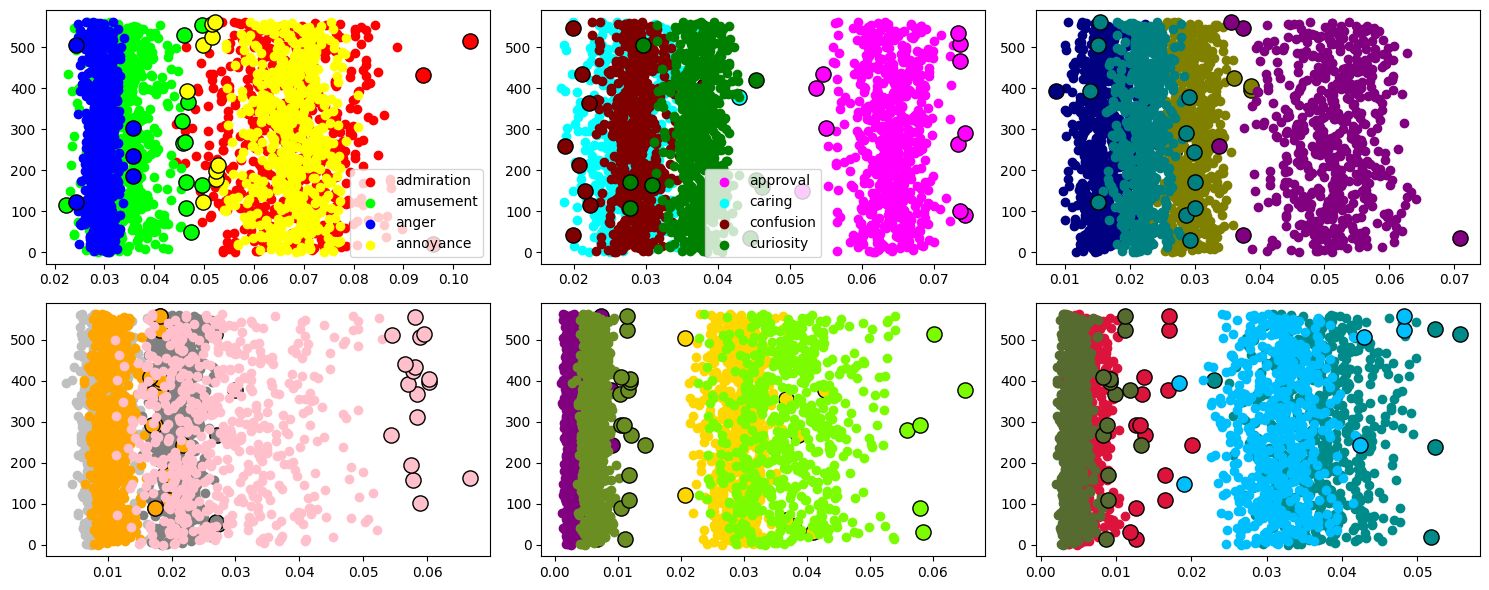

In [533]:
import matplotlib.pyplot as plt
import numpy as np

colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
    '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
    '#C0C0C0', '#808080', '#FFA500', '#FFC0CB', '#800080', '#FFD700',
    '#7CFC00', '#6B8E23', '#008B8B', '#DC143C', '#00BFFF', '#556B2F',
    '#8A2BE2', '#FF1493', '#FF4500', '#DAA520'
  ]
# print(E[0])

# Creating subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns

for i in range(4):
    # Plotting on the first row of subplots
    ax1.scatter(E[i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(E[i])
    ax1.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)


# title = ','.join([emotions[i] for i in range(4)])
# ax1.set_title(f'{title}')  
ax1.legend()
# ax1.legend(labels=[emotions[0],emotions[1],emotions[2], emotions[3]], loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, ncol=4)


for i in range(4, 8):
    # Plotting on the first row of subplots
    ax2.scatter(E[i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(E[i])
    ax2.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(4,8)])
# ax2.set_title(f'{title}') 
ax2.legend()

for i in range(8, 12):
    # Plotting on the first row of subplots
    ax3.scatter(E[i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(E[i])
    ax3.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(8,12)])
# ax3.set_title(f'{title}')
# ax3.legend()

for i in range(12, 16):
    # Plotting on the first row of subplots
    ax4.scatter(E[i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(E[i])
    ax4.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(12,16)])
# ax4.set_title(f'{title}') 
# ax4.legend()

for i in range(16, 20):
    # Plotting on the second row of subplots
    ax5.scatter(E[i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(E[i])
    ax5.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(16,20)])
# ax5.set_title(f'{title}') 
# ax5.legend()

for i in range(20, 24):
    # Plotting on the second row of subplots
    ax6.scatter(E[i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(E[i])
    ax6.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(20,24)])
# ax6.set_title(f'{title}')
# ax6.legend()

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()


In [526]:
def get_Zscore(data):
    # Z-Scores
    z_scores = (data - np.mean(data)) / np.std(data)
    return list(z_scores)

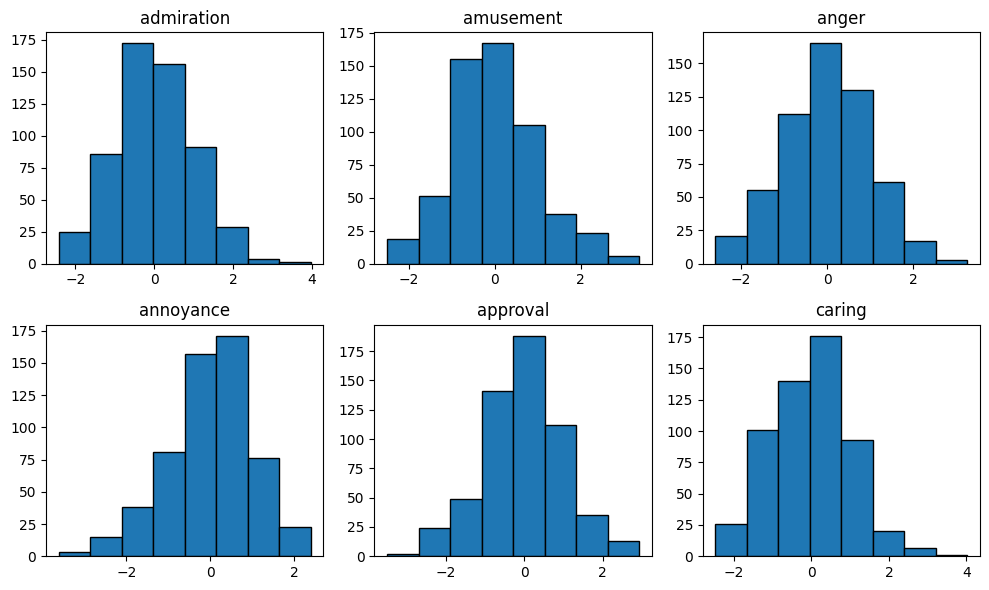

In [527]:
import matplotlib.pyplot as plt
import numpy as np

colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
    '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
    '#C0C0C0', '#808080', '#FFA500', '#FFC0CB', '#800080', '#FFD700',
    '#7CFC00', '#6B8E23', '#008B8B', '#DC143C', '#00BFFF', '#556B2F',
    '#8A2BE2', '#FF1493', '#FF4500', '#DAA520'
  ]
# print(E[0])

# Creating subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))  # 2 rows, 3 columns

ax1.hist(list(get_Zscore(E[0])), bins=8, edgecolor='black')
ax1.set_title(f'{emotions[0]}')

ax2.hist(list(get_Zscore(E[1])), bins=8, edgecolor='black')
ax2.set_title(f'{emotions[1]}')

ax3.hist(list(get_Zscore(E[2])), bins=8, edgecolor='black')
ax3.set_title(f'{emotions[2]}')

ax4.hist(list(get_Zscore(E[3])), bins=8, edgecolor='black')
ax4.set_title(f'{emotions[3]}')

ax5.hist(list(get_Zscore(E[4])), bins=8, edgecolor='black')
ax5.set_title(f'{emotions[4]}')

ax6.hist(list(get_Zscore(E[5])), bins=8, edgecolor='black')
ax6.set_title(f'{emotions[5]}')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()


In [528]:
# import matplotlib.pyplot as plt

# # Creating the histogram
# plt.hist(list(z_scores), bins=8, edgecolor='black')  # Adjust the number of bins as needed
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Histogram')
# # plt.grid(True)
# plt.show()

In [529]:
def get_single_emotion_score(scores):
    data = np.array(scores)
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    # Marking outliers based on z-scores
    outliers = np.where((z_scores <= 1.0))  # Example condition for outliers (modify as needed)
    # Highlighting outliers with a different color and marker
    print(outliers[0])

    result = [data[i] for i in list(outliers[0])]
    return np.mean(result)

In [530]:
get_single_emotion_score(E[0])

[  2   3   4   5   8   9  10  11  12  14  15  18  20  22  23  26  27  28
  29  30  31  32  33  34  35  36  38  39  40  42  43  45  46  48  51  52
  53  54  55  57  59  60  61  62  63  64  65  67  69  71  72  74  75  77
  78  80  81  82  83  84  86  88  90  91  93  94  95  96  97  98  99 100
 101 103 104 105 106 107 109 110 112 114 116 118 120 124 125 128 129 130
 131 132 134 135 137 139 140 142 143 146 147 148 150 152 153 154 155 156
 158 160 161 162 163 164 166 167 170 172 173 174 177 179 180 181 182 184
 186 187 188 189 190 191 192 193 194 195 196 198 199 200 201 202 205 206
 207 208 209 214 215 216 219 221 222 223 225 226 228 230 232 233 234 237
 240 242 243 244 245 248 251 252 254 255 256 257 258 259 260 262 264 265
 266 267 272 273 274 276 277 278 279 280 281 282 285 287 288 290 292 294
 298 300 301 302 303 306 307 309 310 312 315 316 317 318 319 320 321 323
 324 325 326 327 331 332 333 334 335 337 338 339 340 342 343 345 346 347
 348 351 353 354 355 356 358 360 361 362 363 364 36

0.06634664420212766